# Starbucks Capstone Challenge

# Section 1 : Business Understanding

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Section 2 : Data Understanding

### A Look at the Data
First, let's import necessary libraries

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import json
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from time import time
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgbm 

### Gather Data
Let's take a look at some of the characteristics of our dataset. We shall start by loading the data

In [8]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#### 1. Portfolio Dataset

In [9]:
# Display the first few rows of the dataset
print("First few rows:")
portfolio.head()

First few rows:


reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [10]:
# Display total number of rows and columns
print('Portfolio: ',portfolio.shape)

Portfolio:  (10, 6)


In [11]:
# Display summary statistics of numerical columns
print("\nSummary statistics:")
print(portfolio.describe())


Summary statistics:
          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000


In [12]:
# Display information about the DataFrame including column names and data types
print("\nDataFrame info:")
print(portfolio.info())


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes
None


In [13]:
# Check for any missing values
print("\nMissing values:")
print(portfolio.isnull().sum())


Missing values:
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64


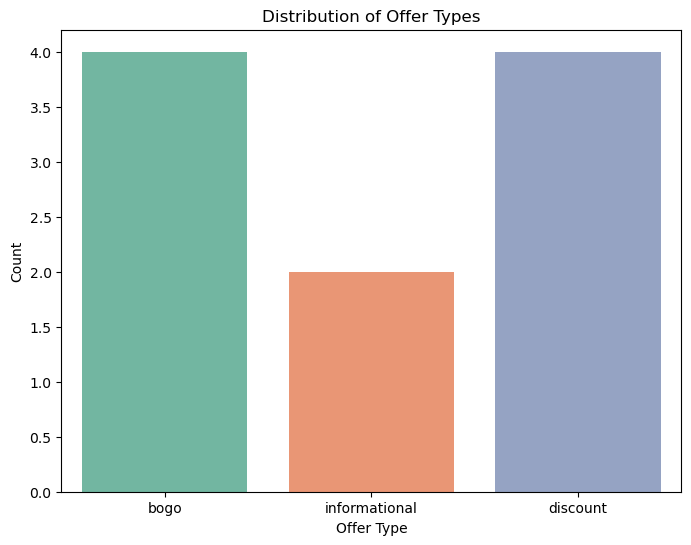

In [16]:
# This plot shows you how many offers belong to each type
plt.figure(figsize=(8, 6))
sns.countplot(x='offer_type', data=portfolio, palette='Set2')
plt.title('Distribution of Offer Types')
plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.show()

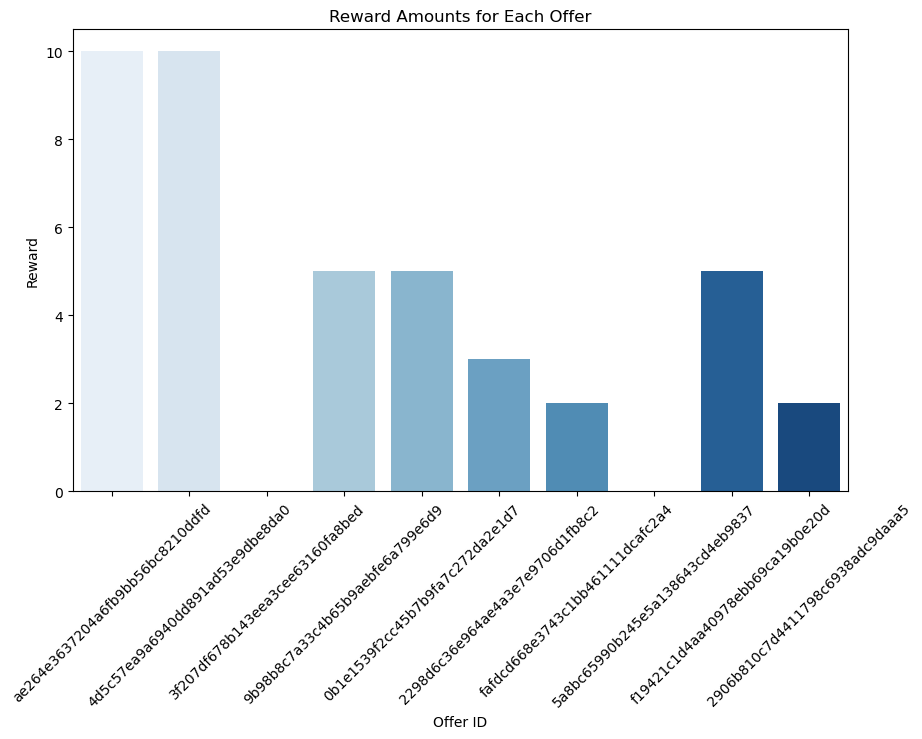

In [17]:
# This plot displays the reward amounts associated with each offer ID.
plt.figure(figsize=(10, 6))
sns.barplot(x='id', y='reward', data=portfolio, palette='Blues')
plt.title('Reward Amounts for Each Offer')
plt.xlabel('Offer ID')
plt.ylabel('Reward')
plt.xticks(rotation=45)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


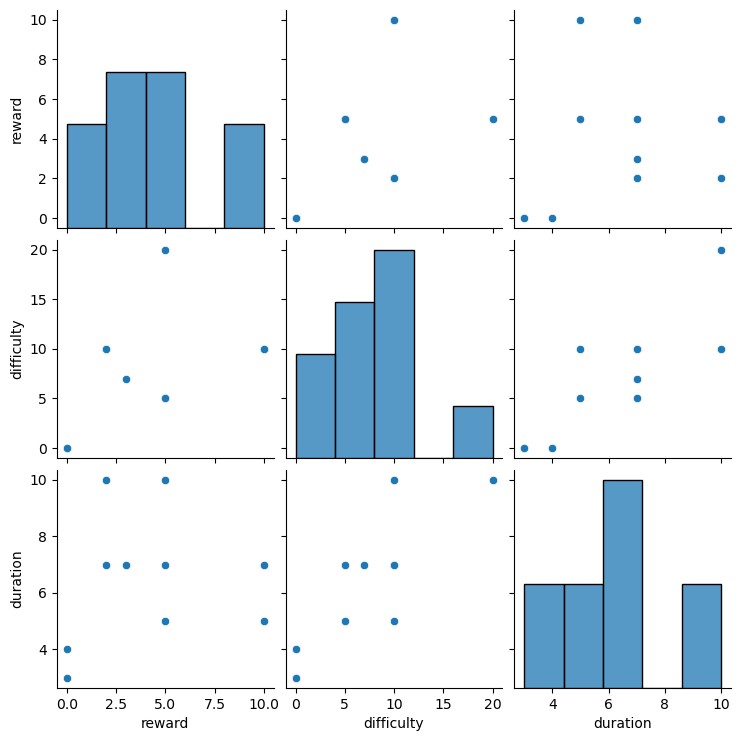

In [18]:
# Pairplot for numerical columns
sns.pairplot(portfolio[['reward', 'difficulty', 'duration']])

#### 2. Profile Dataset

In [19]:
# Display the first few rows of the dataset
print("First few rows:")
profile.head()

First few rows:


gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [20]:
# Display total number of rows and columns
print('Profile: ',profile.shape)

Profile:  (17000, 5)


In [21]:
# Display summary statistics of numerical columns
print("\nSummary statistics:")
print(profile.describe())


Summary statistics:
                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000


In [22]:
# Display information about the DataFrame including column names and data types
print("\nDataFrame info:")
print(profile.info())


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None


In [23]:
# Check for any missing values
print("\nMissing values:")
print(profile.isnull().sum())


Missing values:
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


In [24]:
# Show how many times each unique value appears in the gender column.
profile['gender'].value_counts()

gender
M    8484
F    6129
O     212
Name: count, dtype: int64

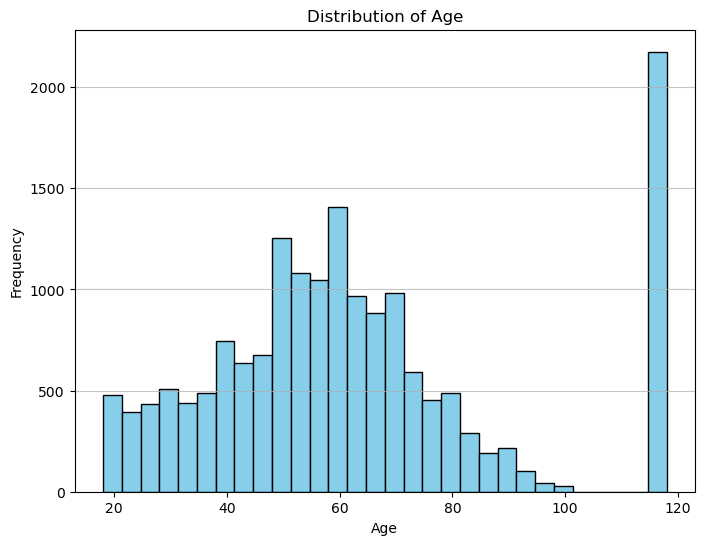

In [25]:
# This will display a histogram showing how ages are distributed across profile dataset.
plt.figure(figsize=(8, 6))
plt.hist(profile['age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

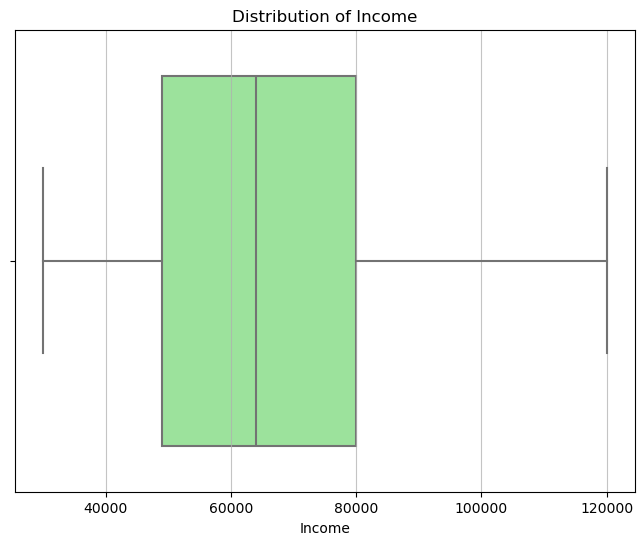

In [26]:
# This boxplot will help us to see the spread of income values and identify any outliers.
plt.figure(figsize=(8, 6))
sns.boxplot(x=profile['income'], color='lightgreen')
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.grid(axis='x', alpha=0.75)
plt.show()

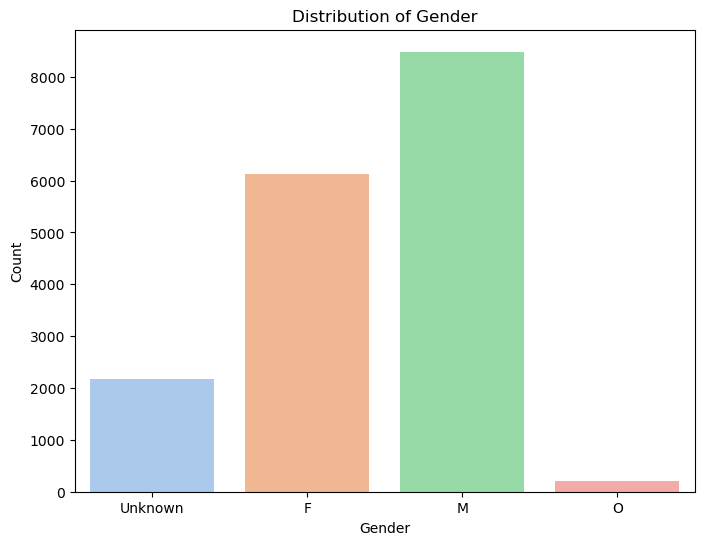

In [27]:
# This count plot will show us how many individuals are recorded for each gender category.
plt.figure(figsize=(8, 6))
sns.countplot(x=profile['gender'].fillna('Unknown'), palette='pastel')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

#### 3. Transcript Dataset

In [28]:
# Display the first few rows of the dataset
print("First few rows:")
transcript.head()

First few rows:


person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [29]:
# Display total number of rows and columns
print('Transcript: ',transcript.shape)

Transcript:  (306534, 4)


In [30]:
# Display summary statistics of numerical columns
print("\nSummary statistics:")
print(transcript.describe())


Summary statistics:
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000


In [31]:
# Display information about the DataFrame including column names and data types
print("\nDataFrame info:")
print(transcript.info())


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None


In [32]:
# Check for any missing values
print("\nMissing values:")
print(transcript.isnull().sum())


Missing values:
person    0
event     0
value     0
time      0
dtype: int64


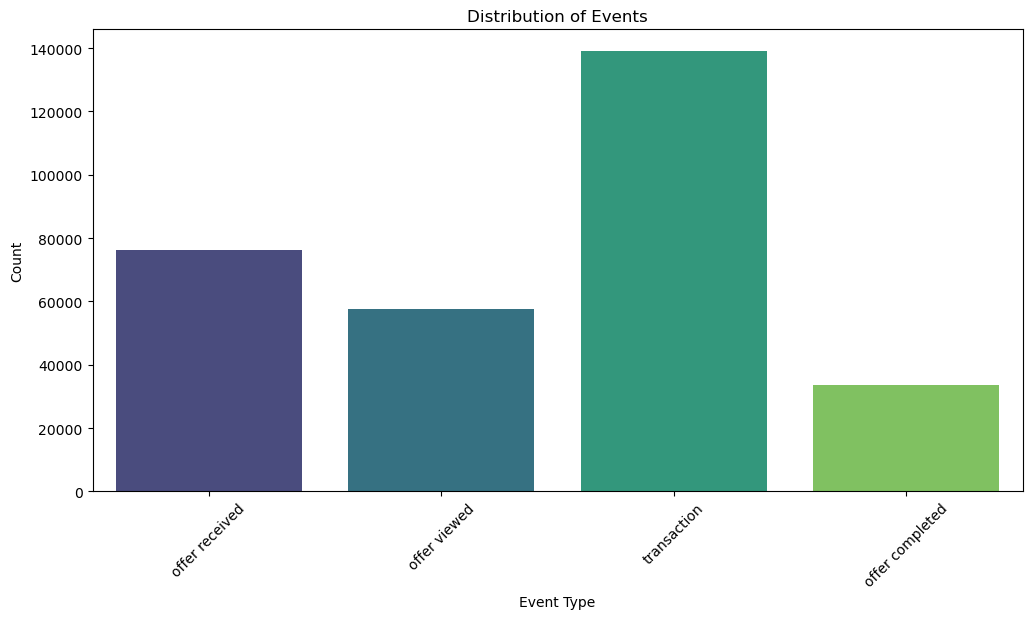

In [33]:
# This plot displays the distribution of different event types recorded in the transcript dataset.
plt.figure(figsize=(12, 6))
sns.countplot(x='event', data=transcript, palette='viridis')
plt.title('Distribution of Events')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

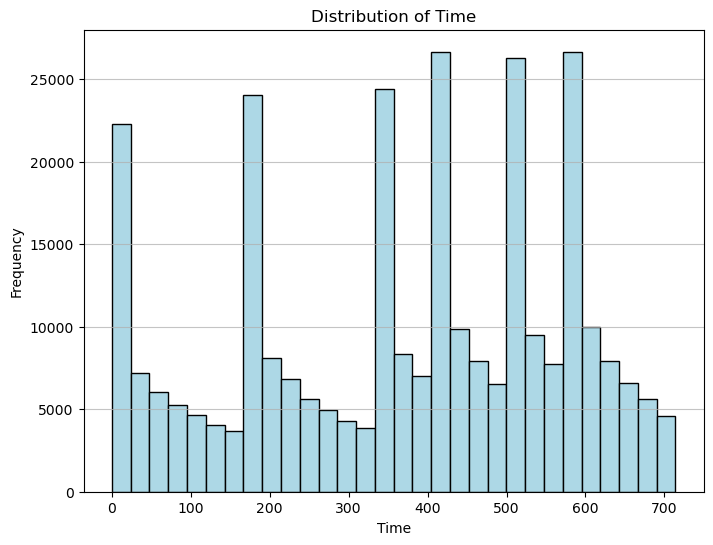

In [34]:
# This histogram shows the distribution of time values, which might represent timestamps or durations of events.
plt.figure(figsize=(8, 6))
plt.hist(transcript['time'], bins=30, color='lightblue', edgecolor='black')
plt.title('Distribution of Time')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Section 3 : Data Preparation

### Clean Data

This step involves several steps to ensure that data is accurate, consistent, and ready for analysis : 
1. Identify and Handle Missing Values
2. Remove Duplicates
3. Correct Data Types
4. Normalize and Standardize Data
5. Handle Outliers
6. Etc..

#### 1. Portfolio dataset 

In [35]:
portfolio.head()

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

Transform the "channels" column into individual binary columns representing each channel present in the dataset: email, web, mobile, and social.

In [36]:
channel_dummies = portfolio['channels'].apply(lambda x: str(x)[1:-1].replace('\'',''))
channel_dummies = channel_dummies.str.get_dummies(sep = ', ')
channel_dummies.head()

email  mobile  social  web
0      1       1       1    0
1      1       1       1    1
2      1       1       0    1
3      1       1       0    1
4      1       0       0    1

Transform the "offer_type" variable into separate binary columns representing each distinct offer type.

In [37]:
offer_dummies = pd.get_dummies(portfolio['offer_type'])
offer_dummies = offer_dummies.applymap(lambda x: 1 if x == 1 else 0)
offer_dummies.head()

/var/folders/wj/8p0pddvs0xg8lggt08n1s1c00000gn/T/ipykernel_4178/2646970787.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  offer_dummies = offer_dummies.applymap(lambda x: 1 if x == 1 else 0)


bogo  discount  informational
0     1         0              0
1     1         0              0
2     0         0              1
3     1         0              0
4     0         1              0

In [38]:
# Concatinate new columns to portofolio and remove old columns
portfolio = pd.concat([portfolio,offer_dummies,channel_dummies],axis=1).drop(['channels'],axis=1)
portfolio.head()

reward  difficulty  duration     offer_type  \
0      10          10         7           bogo   
1      10          10         5           bogo   
2       0           0         4  informational   
3       5           5         7           bogo   
4       5          20        10       discount   

                                 id  bogo  discount  informational  email  \
0  ae264e3637204a6fb9bb56bc8210ddfd     1         0              0      1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0     1         0              0      1   
2  3f207df678b143eea3cee63160fa8bed     0         0              1      1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9     1         0              0      1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7     0         1              0      1   

   mobile  social  web  
0       1       1    0  
1       1       1    1  
2       1       0    1  
3       1       0    1  
4       0       0    1

rename the column 'id' to 'offer_id':

In [39]:
#rename the column 'id' to 'offer_id':
portfolio.rename(columns={"id":"offer_id"},inplace=True)
portfolio.head()

reward  difficulty  duration     offer_type  \
0      10          10         7           bogo   
1      10          10         5           bogo   
2       0           0         4  informational   
3       5           5         7           bogo   
4       5          20        10       discount   

                           offer_id  bogo  discount  informational  email  \
0  ae264e3637204a6fb9bb56bc8210ddfd     1         0              0      1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0     1         0              0      1   
2  3f207df678b143eea3cee63160fa8bed     0         0              1      1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9     1         0              0      1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7     0         1              0      1   

   mobile  social  web  
0       1       1    0  
1       1       1    1  
2       1       0    1  
3       1       0    1  
4       0       0    1

In [40]:
#check for null values
portfolio.isnull().sum()

reward           0
difficulty       0
duration         0
offer_type       0
offer_id         0
bogo             0
discount         0
informational    0
email            0
mobile           0
social           0
web              0
dtype: int64

In [41]:
#check for duplicates
portfolio[portfolio.duplicated()].sum()

reward           0
difficulty       0
duration         0
offer_type       0
offer_id         0
bogo             0
discount         0
informational    0
email            0
mobile           0
social           0
web              0
dtype: object

#### 2. Profile dataset 

In [42]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [43]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [44]:
# check null and nan values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

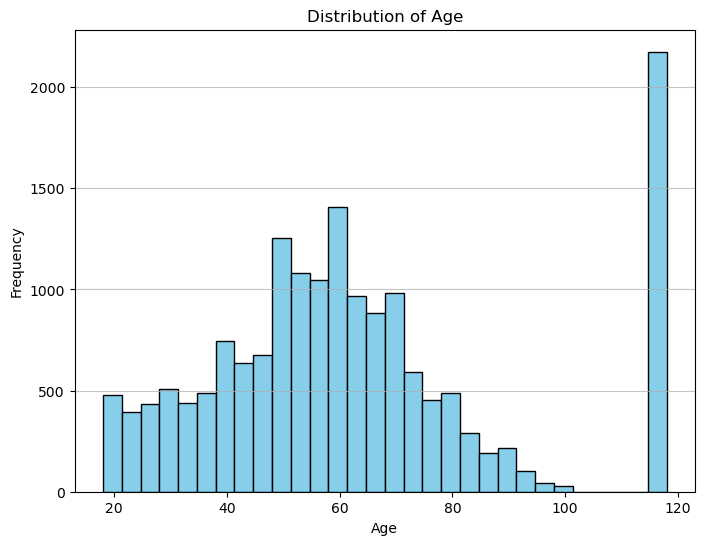

In [45]:
# Check age histogram to deal with outliers.
plt.figure(figsize=(8, 6))
plt.hist(profile['age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Age > 100 are considered as outliers and should be removed


First let's remove null values as they are useless to our analysis, and check if it solves the outlier age issue

In [46]:
#remove the 2175 rows
profile.dropna(inplace=True)

In [47]:
# check again null and nan values
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

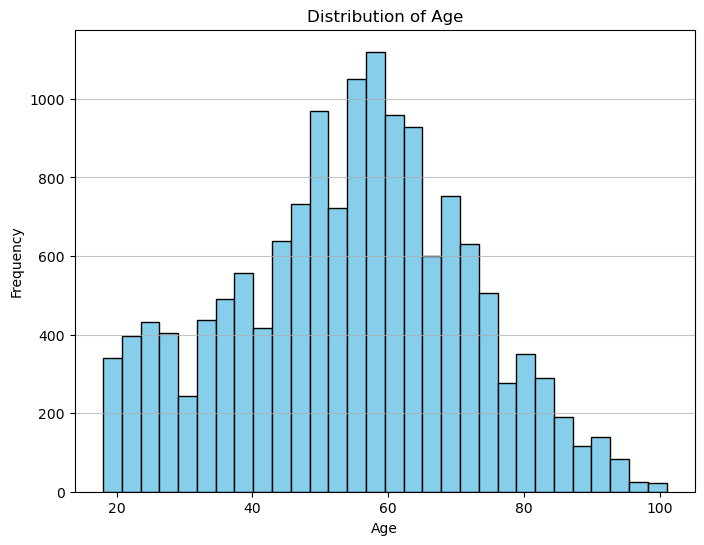

In [48]:
# Check again age histogram to check outliers.
plt.figure(figsize=(8, 6))
plt.hist(profile['age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Outlier issue has been fixed. Means invalid ages were a dummy fill up for rows with null values.

In [49]:
profile.head()

gender  age                                id  became_member_on    income
1       F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
3       F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
5       M   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0
8       M   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0
12      M   58  2eeac8d8feae4a8cad5a6af0499a211d          20171111   51000.0

#### became_member_on column, 
looks like a date but if you take a look on the info method we can see that it's stored as an int64 data which is often used to store integers

In [50]:
# change int64 to datetime data type
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d')

In [51]:
profile.head()

gender  age                                id became_member_on    income
1       F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0
3       F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09  100000.0
5       M   68  e2127556f4f64592b11af22de27a7932       2018-04-26   70000.0
8       M   65  389bc3fa690240e798340f5a15918d5c       2018-02-09   53000.0
12      M   58  2eeac8d8feae4a8cad5a6af0499a211d       2017-11-11   51000.0

In [52]:
#rename the column 'id' to 'profile_id':
profile.rename(columns={"id":"profile_id"},inplace=True)
profile.head()

gender  age                        profile_id became_member_on    income
1       F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0
3       F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09  100000.0
5       M   68  e2127556f4f64592b11af22de27a7932       2018-04-26   70000.0
8       M   65  389bc3fa690240e798340f5a15918d5c       2018-02-09   53000.0
12      M   58  2eeac8d8feae4a8cad5a6af0499a211d       2017-11-11   51000.0

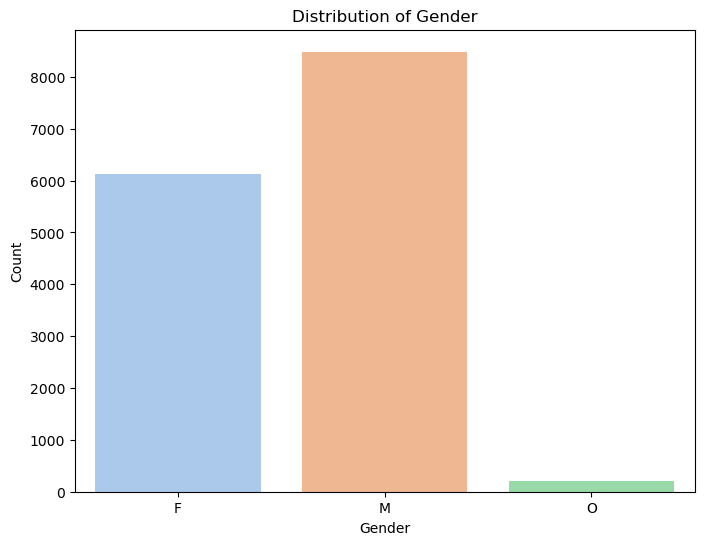

In [53]:
# This count plot will show us how many individuals are recorded for each gender category.
plt.figure(figsize=(8, 6))
sns.countplot(x=profile['gender'].fillna('Unknown'), palette='pastel')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

The profile data looks great now

#### 3. Transcript dataset 

In [54]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

Expand 'value' column's value into new collumns (offer_id, amount, reward)

In [55]:
# Define a function to extract 'offer id' or return nan if it doesn't exist
def extract_offer_id(x):
    """
    Extracts the offer ID from a dictionary-like object `x`.

    This function checks if `x` contains an 'offer id' or 'offer_id' key and returns
    the corresponding value. If neither key is found, it returns `np.nan`.

    Parameters:
    - x (dict): A dictionary-like object where the offer ID is to be extracted.

    Returns:
    - offer_id: The value associated with the 'offer id' or 'offer_id' key in `x`, 
      or `np.nan` if neither key is found.
    """
    if 'offer id' in x:
        return x['offer id']
    elif 'offer_id' in x:
        return x['offer_id']
    else:
        return np.nan

# Define a function to extract 'amount' or return 0 if it doesn't exist
def extract_amount(x):
    """
    Extracts the 'amount' value from a dictionary-like object `x`.

    This function retrieves the value associated with the key 'amount' from 
    the dictionary `x`. If 'amount' key is not present in `x`, it returns 0.

    Parameters:
    - x (dict): A dictionary-like object where the 'amount' value is to be extracted.

    Returns:
    - amount: The value associated with the 'amount' key in `x`, or 0 if 'amount' 
      key is not found.
    """
    return x['amount'] if 'amount' in x else 0

# Define a function to extract 'reward' or return 0 if it doesn't exist
def extract_reward(x):
    """
    Extracts the 'reward' value from a dictionary-like object `x`.

    This function retrieves the value associated with the key 'reward' from 
    the dictionary `x`. If 'reward' key is not present in `x`, it returns 0.

    Parameters:
    - x (dict): A dictionary-like object where the 'reward' value is to be extracted.

    Returns:
    - reward: The value associated with the 'reward' key in `x`, or 0 if 'reward' 
      key is not found.
    """
    return x['reward'] if 'reward' in x else 0

In [56]:
# Create offer_id column to hold the offer id of the value column. If no offer_id, replace it with Nan.
transcript['offer_id'] = transcript.value.apply(extract_offer_id)
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   

                           offer_id  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7  
2  2906b810c7d4411798c6938adc9daaa5  
3  fafdcd668e3743c1bb461111dcafc2a4  
4  4d5c57ea9a6940dd891ad53e9dbe8da0

In [57]:
# Apply the function to each element in transcript.value
transcript['amount'] = transcript['value'].apply(extract_amount)
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   

                           offer_id  amount  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     0.0  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     0.0  
2  2906b810c7d4411798c6938adc9daaa5     0.0  
3  fafdcd668e3743c1bb461111dcafc2a4     0.0  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     0.0

In [58]:
# Apply the function to each element in transcript.value
transcript['reward'] = transcript['value'].apply(extract_reward)
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   

                           offer_id  amount  reward  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     0.0       0  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     0.0       0  
2  2906b810c7d4411798c6938adc9daaa5     0.0       0  
3  fafdcd668e3743c1bb461111dcafc2a4     0.0       0  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     0.0       0

In [59]:
# Remove value column
transcript.drop(['value'],axis=1,inplace=True)
transcript.head()

person           event  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0   
1  a03223e636434f42ac4c3df47e8bac43  offer received     0   
2  e2127556f4f64592b11af22de27a7932  offer received     0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0   
4  68617ca6246f4fbc85e91a2a49552598  offer received     0   

                           offer_id  amount  reward  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     0.0       0  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     0.0       0  
2  2906b810c7d4411798c6938adc9daaa5     0.0       0  
3  fafdcd668e3743c1bb461111dcafc2a4     0.0       0  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     0.0       0

In [60]:
#rename the column 'person' to 'person_id':
transcript.rename(columns={"person":"profile_id"},inplace=True)
transcript.head()

profile_id           event  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0   
1  a03223e636434f42ac4c3df47e8bac43  offer received     0   
2  e2127556f4f64592b11af22de27a7932  offer received     0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0   
4  68617ca6246f4fbc85e91a2a49552598  offer received     0   

                           offer_id  amount  reward  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     0.0       0  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     0.0       0  
2  2906b810c7d4411798c6938adc9daaa5     0.0       0  
3  fafdcd668e3743c1bb461111dcafc2a4     0.0       0  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     0.0       0

In [61]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   profile_id  306534 non-null  object 
 1   event       306534 non-null  object 
 2   time        306534 non-null  int64  
 3   offer_id    167581 non-null  object 
 4   amount      306534 non-null  float64
 5   reward      306534 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 14.0+ MB


In [62]:
transcript.event.value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

#### Expand "event" into binary columns of all different events in the dataset

In [63]:
# Function to create dummy variables with value 1 if true else 0
def create_binary_dummies(df, column_name):
    """
    Create binary dummy variables based on the values in a specified column of a DataFrame.

    This function generates binary dummy variables for the unique values in the specified 
    column `column_name` of the DataFrame `df`. Each unique value in the column becomes 
    a new column with values 1 (True) or 0 (False) indicating the presence of that value.

    Parameters:
    - df (DataFrame): The pandas DataFrame containing the data.
    - column_name (str): The name of the column in `df` for which binary dummy variables 
      are to be created.

    Returns:
    - dummies (DataFrame): A DataFrame of binary dummy variables. Each column corresponds 
      to a unique value in `column_name`, with values 1 if the value exists in `df` for 
      that row, otherwise 0.

    Notes:
    - This function assumes that `column_name` exists in `df` and contains categorical data.
    """
    dummies = pd.get_dummies(df[column_name], prefix=column_name, dummy_na=False)
    dummies = dummies.apply(lambda x: x if x.sum() > 0 else 0, axis=1)  # Convert to 1 if any value exists, otherwise 0
    return dummies

In [64]:
# Split event column into 4 columns: 'offer_received', 'offer_viewed', 'offer_completed' and 'transaction'.
transcript['offer_received'] = transcript['event'].apply(lambda x: 1 if x == 'offer received' else 0)
transcript['offer_viewed'] = transcript['event'].apply(lambda x: 1 if x == 'offer viewed' else 0)
transcript['offer_completed'] = transcript['event'].apply(lambda x: 1 if x == 'offer completed' else 0)
transcript['transaction'] = transcript['event'].apply(lambda x: 1 if x == 'transaction' else 0)

# drop event column
transcript.drop(columns = ['event'], inplace = True)

# check
transcript.head()

profile_id  time                          offer_id  \
0  78afa995795e4d85b5d9ceeca43f5fef     0  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1  a03223e636434f42ac4c3df47e8bac43     0  0b1e1539f2cc45b7b9fa7c272da2e1d7   
2  e2127556f4f64592b11af22de27a7932     0  2906b810c7d4411798c6938adc9daaa5   
3  8ec6ce2a7e7949b1bf142def7d0e0586     0  fafdcd668e3743c1bb461111dcafc2a4   
4  68617ca6246f4fbc85e91a2a49552598     0  4d5c57ea9a6940dd891ad53e9dbe8da0   

   amount  reward  offer_received  offer_viewed  offer_completed  transaction  
0     0.0       0               1             0                0            0  
1     0.0       0               1             0                0            0  
2     0.0       0               1             0                0            0  
3     0.0       0               1             0                0            0  
4     0.0       0               1             0                0            0

In [65]:
# drop duplicates rows if any.
transcript.duplicated().sum() # there are a total of 2962 duplicate rows
transcript.drop_duplicates(inplace = True)

#check
transcript.duplicated().sum()

0

In [66]:
transcript.transaction.value_counts()

transaction
0    167184
1    138953
Name: count, dtype: int64

In [67]:
transcript.shape

(306137, 9)

In [ ]:
### I keep only data in transcript dataset which has profile_id in profile dataset.

In [68]:
# Using ~isin (opposite)
mask_opposite = ~transcript['profile_id'].isin(profile['profile_id'])
mask_opposite.sum()

33749

In [69]:
# keep only data in transcript dataset which has profile_id in profile dataset.
mask = transcript['profile_id'].isin(profile['profile_id'])
transcript = transcript[mask]

In [70]:
transcript.head()

profile_id  time                          offer_id  \
0  78afa995795e4d85b5d9ceeca43f5fef     0  9b98b8c7a33c4b65b9aebfe6a799e6d9   
2  e2127556f4f64592b11af22de27a7932     0  2906b810c7d4411798c6938adc9daaa5   
5  389bc3fa690240e798340f5a15918d5c     0  f19421c1d4aa40978ebb69ca19b0e20d   
7  2eeac8d8feae4a8cad5a6af0499a211d     0  3f207df678b143eea3cee63160fa8bed   
8  aa4862eba776480b8bb9c68455b8c2e1     0  0b1e1539f2cc45b7b9fa7c272da2e1d7   

   amount  reward  offer_received  offer_viewed  offer_completed  transaction  
0     0.0       0               1             0                0            0  
2     0.0       0               1             0                0            0  
5     0.0       0               1             0                0            0  
7     0.0       0               1             0                0            0  
8     0.0       0               1             0                0            0

# Section 3 : Data Preparation


To delve further into exploring the offers in relation to the users and their types, we will need to make modifications to the data.

In [71]:
profile.head()

gender  age                        profile_id became_member_on    income
1       F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0
3       F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09  100000.0
5       M   68  e2127556f4f64592b11af22de27a7932       2018-04-26   70000.0
8       M   65  389bc3fa690240e798340f5a15918d5c       2018-02-09   53000.0
12      M   58  2eeac8d8feae4a8cad5a6af0499a211d       2017-11-11   51000.0

#### Combine the transcript dataset and the portfolio dataset to create a new dataset named 'transcript_portfolio_df'.

In [72]:
transcript_portfolio_df = pd.merge(transcript, portfolio, on='offer_id',how='left')
transcript_portfolio_df.head()

profile_id  time                          offer_id  \
0  78afa995795e4d85b5d9ceeca43f5fef     0  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1  e2127556f4f64592b11af22de27a7932     0  2906b810c7d4411798c6938adc9daaa5   
2  389bc3fa690240e798340f5a15918d5c     0  f19421c1d4aa40978ebb69ca19b0e20d   
3  2eeac8d8feae4a8cad5a6af0499a211d     0  3f207df678b143eea3cee63160fa8bed   
4  aa4862eba776480b8bb9c68455b8c2e1     0  0b1e1539f2cc45b7b9fa7c272da2e1d7   

   amount  reward_x  offer_received  offer_viewed  offer_completed  \
0     0.0         0               1             0                0   
1     0.0         0               1             0                0   
2     0.0         0               1             0                0   
3     0.0         0               1             0                0   
4     0.0         0               1             0                0   

   transaction  reward_y  difficulty  duration     offer_type  bogo  discount  \
0            0       5.0         5.0       7.0           bogo   1.0       0.0   
1            0       2.0        10.0       7.0       discount   0.0       1.0   
2            0       5.0         5.0       5.0           bogo   1.0       0.0   
3            0       0.0         0.0       4.0  informational   0.0       0.0   
4            0       5.0        20.0      10.0       discount   0.0       1.0   

   informational  email  mobile  social  web  
0            0.0    1.0     1.0     0.0  1.0  
1            0.0    1.0     1.0     0.0  1.0  
2            0.0    1.0     1.0     1.0  1.0  
3            1.0    1.0     1.0     0.0  1.0  
4            0.0    1.0     0.0     0.0  1.0

# Section 4 : Data Visual Explorations

The process of data visual exploration involves several key steps to effectively understand and communicate insights from data.

In [73]:
sns.set()
base_color = sns.color_palette()

### Question 1 : How many Bogo (Buy One Get One), discount, and informational offers were received by users?

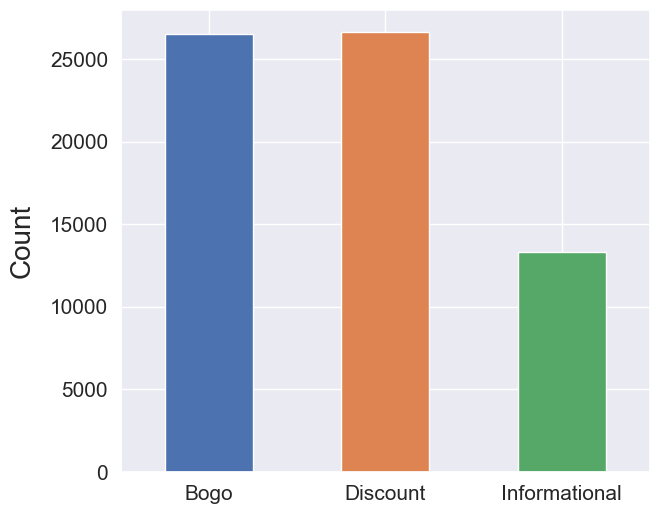

In [74]:
received_offer_types = transcript_portfolio_df[transcript_portfolio_df['offer_received']==1][['bogo','discount','informational']].sum()

# Plotting
plt.figure(figsize = [15,6])

# Bar chart
plt.subplot(1,2,1)
received_offer_types.plot(kind='bar',color=base_color)
plt.xticks([0,1,2],['Bogo','Discount','Informational'],rotation = 0,fontsize=15);
plt.ylabel('Count',fontsize=20,labelpad=10,rotation = 90)
plt.yticks(fontsize=15);


##### Over 26,500 of the received offers are Bogo (Buy One Get One), over 26, 600 are discount few of received offers 13, 300 are informational.

Text(0, 0.5, '')

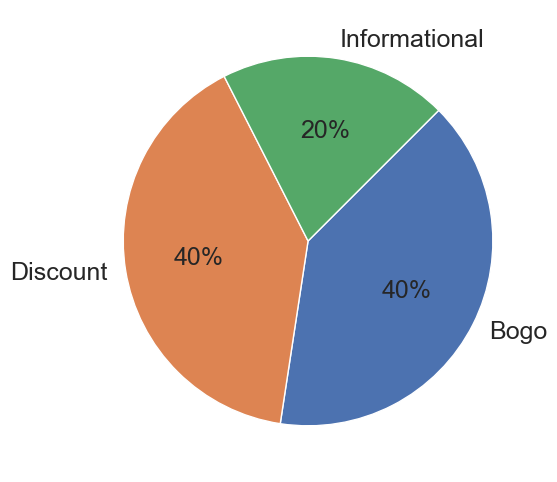

In [75]:
# Plotting
plt.figure(figsize = [15,6])

# Pie chart
plt.subplot(1,2,2)
received_offer_types.plot(kind='pie',startangle = 45,counterclock=False,autopct='%1.0f%%',\
                labels=['Bogo','Discount','Informational'],\
                textprops={'fontsize': 18})
plt.ylabel('')


### Question 2 :What is the distribution of gender among the profiles in the dataset?

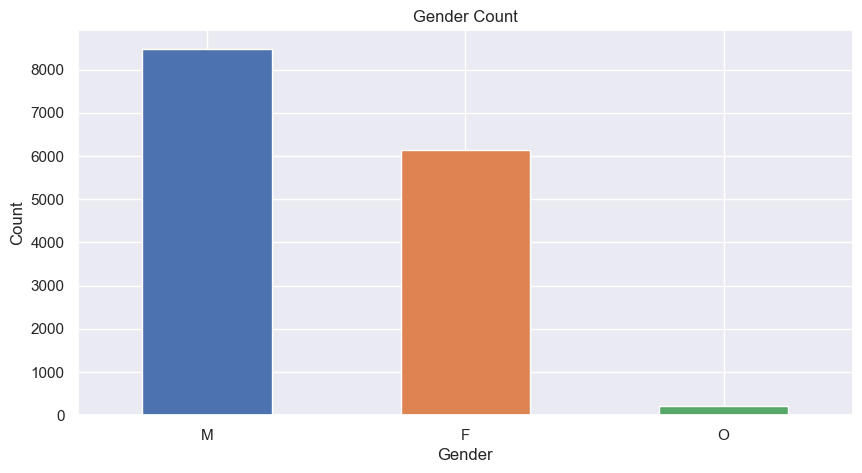

In [76]:
fig = plt.figure(figsize = (10,5))
ax = profile.gender.value_counts().plot(kind = 'bar',color=base_color)

plt.xticks(rotation = 360)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Count');

##### Over 8,000 of the Starbucks profile collected identify as male while about 6,000 identify as feamle. Very few customer identify as 'Others'.

### Question 3 : How is the age and gender distributed among the users in the dataset?

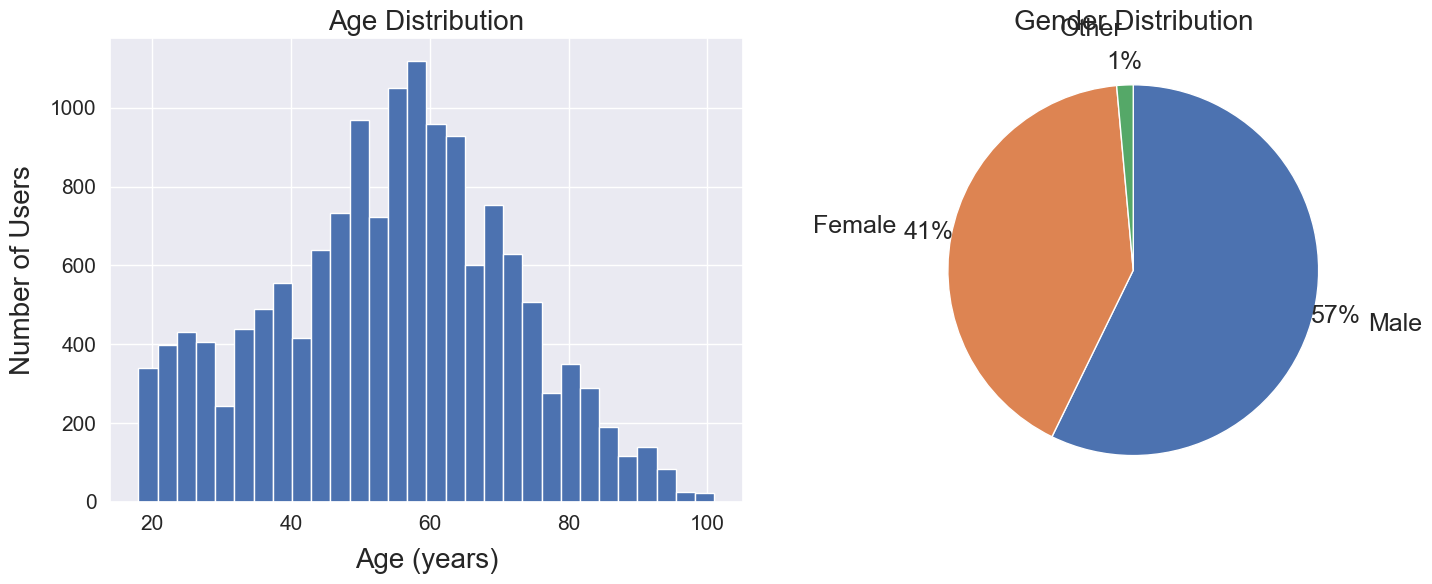

In [78]:
# Prepare data
age_dist = profile['age']
gend_dist = profile['gender'].value_counts()

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Age Histogram
axs[0].hist(age_dist, bins=30)
axs[0].set_title('Age Distribution', fontsize=20)
axs[0].set_xlabel('Age (years)', fontsize=20, labelpad=10)
axs[0].set_ylabel('Number of Users', fontsize=20, labelpad=10)
axs[0].tick_params(axis='both', which='major', labelsize=15)

# Plot 2: Gender Pie Chart
labels = ['Male', 'Female', 'Other']
axs[1].pie(gend_dist, labels=labels, startangle=90, counterclock=False, autopct='%1.0f%%', 
           textprops={'fontsize': 18}, pctdistance=1.12, labeldistance=1.3)
axs[1].set_title('Gender Distribution', fontsize=20)
axs[1].set_ylabel('')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

### Question 4 : How many times did each event (offer received, offer viewed, offer completed, and transaction) occur in the transcript dataset?

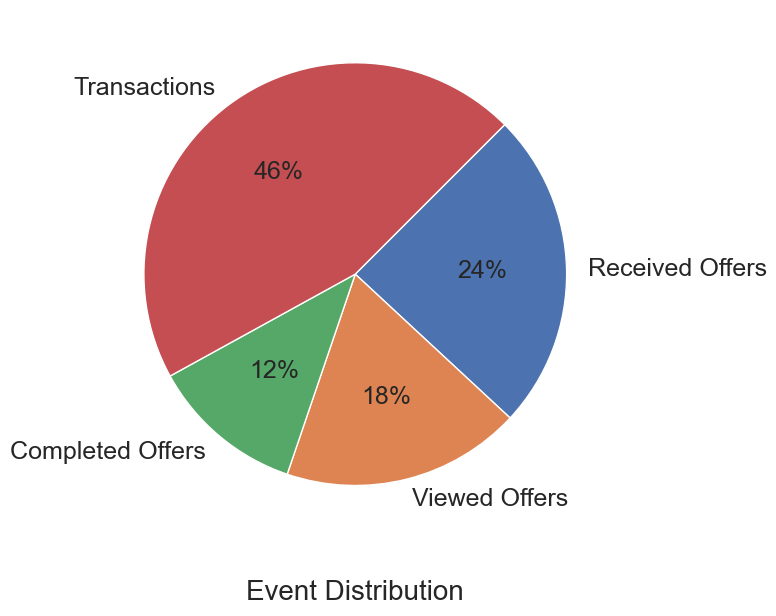

In [79]:
event_dist = transcript[['offer_received','offer_viewed','offer_completed','transaction']].sum()

# Plotting
plt.figure(figsize = [15,8])

# Pie chart
plt.subplot(1,2,2)
event_dist.plot(kind='pie',startangle = 45,counterclock=False,autopct='%1.0f%%',\
                labels=['Received Offers','Viewed Offers','Completed Offers','Transactions'],\
                textprops={'fontsize': 18})
plt.ylabel('')
plt.xlabel('Event Distribution',fontsize=20,labelpad=30);

### Question 5 : What does the distribution of income look like among individuals in the dataset?

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


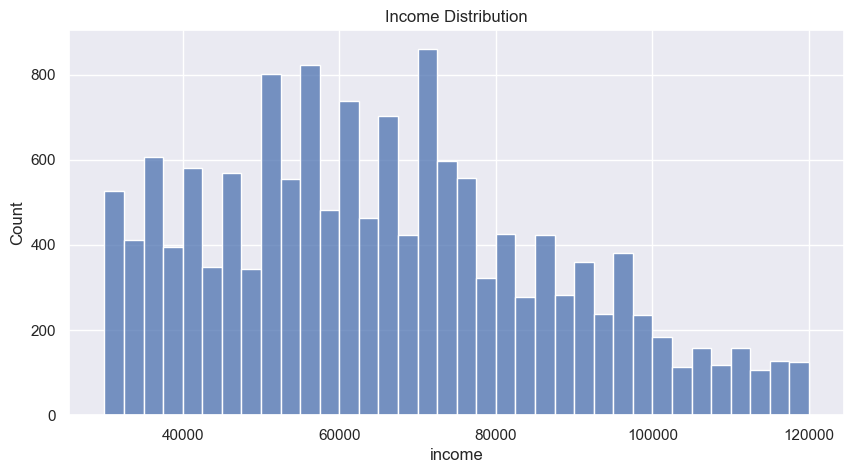

In [80]:
fig = plt.figure(figsize = (10,5))
sns.histplot(data = profile, x = 'income')
plt.title('Income Distribution');

##### The income distribution is slightly right-skewed, with the peak occurring around the $70,000 mark, and most individuals earning less than that. I'm curious to see how this distribution varies when segmented by gender.

### Question 5 : What's the age distributions of individuals categorized by gender 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


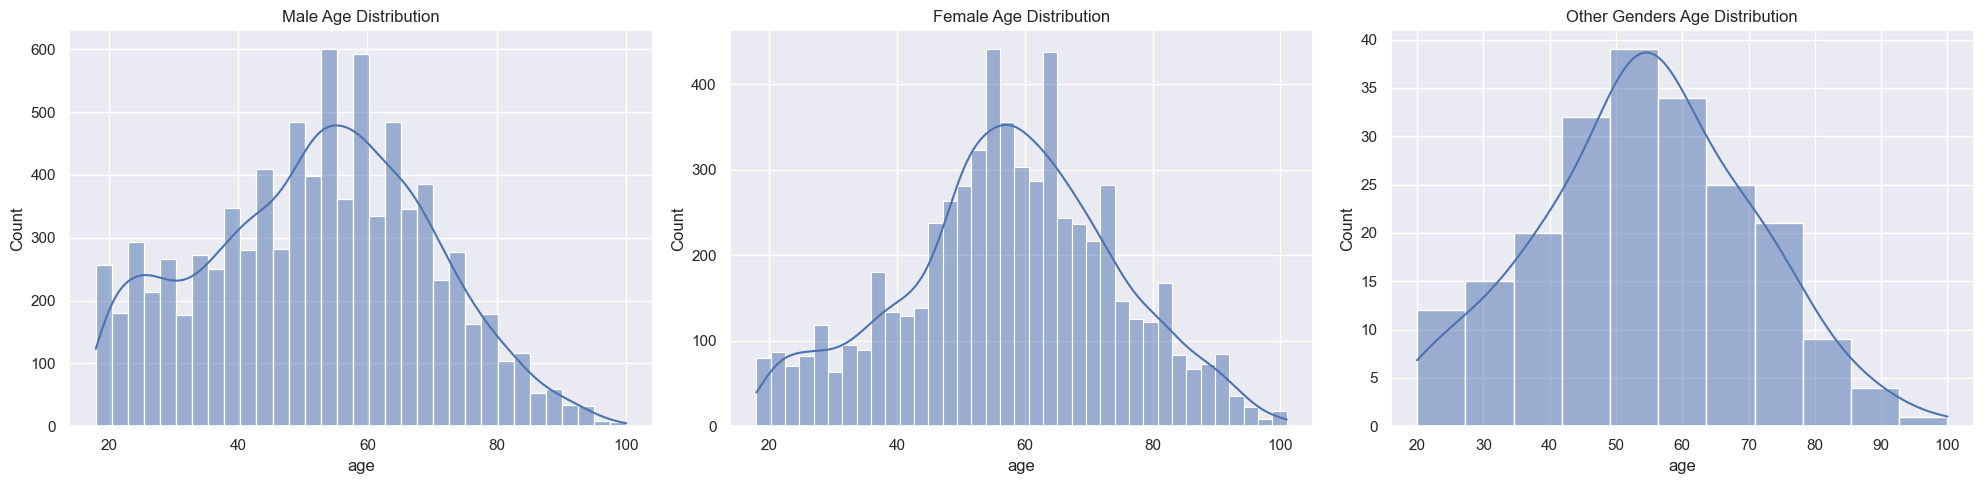

In [81]:
# Create subplots with 1 row and 3 columns
fig, ax = plt.subplots(1, 3, figsize=[20, 5])

# Plot male age distribution
sns.histplot(profile.query('gender == "M"')['age'], ax=ax[0], kde=True)
ax[0].set_title('Male Age Distribution')

# Plot female age distribution
sns.histplot(profile.query('gender == "F"')['age'], ax=ax[1], kde=True)
ax[1].set_title('Female Age Distribution')

# Plot other genders age distribution
sns.histplot(profile.query('gender == "O"')['age'], ax=ax[2], kde=True)
ax[2].set_title('Other Genders Age Distribution')

# Display the plots
plt.tight_layout()
plt.show()

# Section 5 : Data Modelling

Data modeling is a crucial process in data science and analytics that involves structuring and organizing data to understand relationships, patterns, and insights.

Having analyzed the dataset, our next step is to develop a predictive model for determining user response to offers. 
##### We anticipate four possible scenarios:
1. A user will both view and complete the offer.
2. A user will only view the offer.
3. A user will complete the offer without having viewed it beforehand.
4. A user will neither view nor complete the offer.

##### Merge transcript_portfolio_df dataset and profile dataset to create final df.

In [82]:
df = transcript_portfolio_df.merge(profile, how = 'inner', on = 'profile_id')
df.head()

profile_id  time                          offer_id  \
0  78afa995795e4d85b5d9ceeca43f5fef     0  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1  78afa995795e4d85b5d9ceeca43f5fef     6  9b98b8c7a33c4b65b9aebfe6a799e6d9   
2  78afa995795e4d85b5d9ceeca43f5fef   132                               NaN   
3  78afa995795e4d85b5d9ceeca43f5fef   132  9b98b8c7a33c4b65b9aebfe6a799e6d9   
4  78afa995795e4d85b5d9ceeca43f5fef   144                               NaN   

   amount  reward_x  offer_received  offer_viewed  offer_completed  \
0    0.00         0               1             0                0   
1    0.00         0               0             1                0   
2   19.89         0               0             0                0   
3    0.00         5               0             0                1   
4   17.78         0               0             0                0   

   transaction  reward_y  ...  discount  informational email  mobile  social  \
0            0       5.0  ...       0.0            0.0   1.0     1.0     0.0   
1            0       5.0  ...       0.0            0.0   1.0     1.0     0.0   
2            1       NaN  ...       NaN            NaN   NaN     NaN     NaN   
3            0       5.0  ...       0.0            0.0   1.0     1.0     0.0   
4            1       NaN  ...       NaN            NaN   NaN     NaN     NaN   

   web  gender  age  became_member_on    income  
0  1.0       F   75        2017-05-09  100000.0  
1  1.0       F   75        2017-05-09  100000.0  
2  NaN       F   75        2017-05-09  100000.0  
3  1.0       F   75        2017-05-09  100000.0  
4  NaN       F   75        2017-05-09  100000.0  

[5 rows x 24 columns]

##### Let's convert each element of gender and make sure it corresponds to the numerical encoding based.

In [83]:
df['gender'] = df.gender.apply(lambda x: 
                       1 if x == 'F' else   # Assign 1 if gender is 'F'
                       2 if x == 'M' else   # Assign 2 if gender is 'M'
                       3 if x == 'O' else   # Assign 3 if gender is 'O'
                       np.nan               # Assign np.nan for any other values
                      )
df.gender.unique()

array([1, 2, 3])

##### Let's keep only the columns needed to our modeling. We select specific columns from a DataFrame df

In [84]:
new_df = df[['difficulty', 'age', 'income','time', 'amount', 'offer_completed', 
                        'gender','reward_y', 'became_member_on']]

In [85]:
new_df

difficulty  age    income  time  amount  offer_completed  gender  \
0              5.0   75  100000.0     0    0.00                0       1   
1              5.0   75  100000.0     6    0.00                0       1   
2              NaN   75  100000.0   132   19.89                0       1   
3              5.0   75  100000.0   132    0.00                1       1   
4              NaN   75  100000.0   144   17.78                0       1   
...            ...  ...       ...   ...     ...              ...     ...   
272383         0.0   47   94000.0   504    0.00                0       2   
272384        10.0   47   94000.0   576    0.00                0       2   
272385        10.0   47   94000.0   576    0.00                0       2   
272386        10.0   58   78000.0   576    0.00                0       1   
272387        10.0   58   78000.0   576    0.00                0       1   

        reward_y became_member_on  
0            5.0       2017-05-09  
1            5.0       2017-05-09  
2            NaN       2017-05-09  
3            5.0       2017-05-09  
4            NaN       2017-05-09  
...          ...              ...  
272383       0.0       2017-10-13  
272384      10.0       2017-10-13  
272385      10.0       2017-10-13  
272386      10.0       2016-10-20  
272387      10.0       2016-10-20  

[272388 rows x 9 columns]

In [86]:
# Drop all income with null values.
new_df.dropna(subset=['income'], inplace = True)

/var/folders/wj/8p0pddvs0xg8lggt08n1s1c00000gn/T/ipykernel_4178/1037906010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.dropna(subset=['income'], inplace = True)


In [87]:
# Fill all null values with 0.
new_df.fillna(0, inplace = True)

/var/folders/wj/8p0pddvs0xg8lggt08n1s1c00000gn/T/ipykernel_4178/3316753486.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.fillna(0, inplace = True)


In [88]:
new_df.isnull().sum()

difficulty          0
age                 0
income              0
time                0
amount              0
offer_completed     0
gender              0
reward_y            0
became_member_on    0
dtype: int64

In [89]:
new_df['became_member_on'] = new_df['became_member_on'].dt.year

#check
new_df.head()

/var/folders/wj/8p0pddvs0xg8lggt08n1s1c00000gn/T/ipykernel_4178/2471342806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['became_member_on'] = new_df['became_member_on'].dt.year


difficulty  age    income  time  amount  offer_completed  gender  reward_y  \
0         5.0   75  100000.0     0    0.00                0       1       5.0   
1         5.0   75  100000.0     6    0.00                0       1       5.0   
2         0.0   75  100000.0   132   19.89                0       1       0.0   
3         5.0   75  100000.0   132    0.00                1       1       5.0   
4         0.0   75  100000.0   144   17.78                0       1       0.0   

   became_member_on  
0              2017  
1              2017  
2              2017  
3              2017  
4              2017

In [90]:
X = new_df[['time', 'amount','reward_y', 'difficulty', 'age', 'income', 'gender', 'became_member_on']]
y =  new_df['offer_completed']

In [102]:
X.head()

time  amount  reward_y  difficulty  age    income  gender  became_member_on
0     0    0.00       5.0         5.0   75  100000.0       1              2017
1     6    0.00       5.0         5.0   75  100000.0       1              2017
2   132   19.89       0.0         0.0   75  100000.0       1              2017
3   132    0.00       5.0         5.0   75  100000.0       1              2017
4   144   17.78       0.0         0.0   75  100000.0       1              2017

In [91]:
# Normalize help: https://datagy.io/pandas-normalize-column/
scaler = MinMaxScaler()
normalize_col = list(X.columns)

X[normalize_col] = scaler.fit_transform(X[normalize_col])

/var/folders/wj/8p0pddvs0xg8lggt08n1s1c00000gn/T/ipykernel_4178/2217599478.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[normalize_col] = scaler.fit_transform(X[normalize_col])


In [92]:
X.head()

time    amount  reward_y  difficulty       age    income  gender  \
0  0.000000  0.000000       0.5        0.25  0.686747  0.777778     0.0   
1  0.008403  0.000000       0.5        0.25  0.686747  0.777778     0.0   
2  0.184874  0.018724       0.0        0.00  0.686747  0.777778     0.0   
3  0.184874  0.000000       0.5        0.25  0.686747  0.777778     0.0   
4  0.201681  0.016738       0.0        0.00  0.686747  0.777778     0.0   

   became_member_on  
0               0.8  
1               0.8  
2               0.8  
3               0.8  
4               0.8

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [94]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((204291, 8), (68097, 8), (204291,), (68097,))

In [95]:
# checking for accuracy imbalance
(new_df.offer_completed.value_counts()/new_df.offer_completed.count())*100

offer_completed
0    88.226354
1    11.773646
Name: count, dtype: float64

##### It's clear that the 'offer_completed' variable in the dataset is extremely imbalanced. Given its significant underrepresentation, we've opted to use the F1-score as our metric."

In [129]:
def logistic_regression(X_train, X_test, y_train, y_test):
    """
    Perform logistic regression on the given training and test data.

    This function creates a Logistic Regression model, trains it on the 
    training data (`X_train`, `y_train`), makes predictions on the test data 
    (`X_test`), and then evaluates the model's performance using accuracy, 
    F1-score, and classification report.

    Parameters:
    - X_train (array-like): Training input samples.
    - X_test (array-like): Test input samples.
    - y_train (array-like): Target values for training.
    - y_test (array-like): Target values for testing.

    Prints:
    - Accuracy: The accuracy of the logistic regression model on the test data.
    - F1-Score: The F1-score of the logistic regression model on the test data.
    - Total Time Spent Modeling: The total time taken to train and predict with the model.
    - Classification Report: Detailed metrics including precision, recall, F1-score, and support.

    Returns:
    - Logistic Regression Model and total time
    """
    start = time()

    # Creating a Logistic Regression model
    lr_model = LogisticRegression()
    # Training the model
    lr_model.fit(X_train, y_train)
    # Making predictions
    lr_pred = lr_model.predict(X_test)
    
    end = time()
    lr_total_time = end - start
    
    # Calculating accuracy
    accuracy = accuracy_score(y_test, lr_pred)

    # Printing results
    print("Logistic Regression Model Results:")
    print("=================================")
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("F1-Score:", f1_score(y_test, lr_pred))
    print("Total Time Spent Modeling:", lr_total_time, "seconds")
    print('Classification Report: \n', classification_report(y_test, lr_pred))
    return lr_pred,lr_total_time

def ada_boost_classifier(X_train, X_test, y_train, y_test):
    """
    Perform AdaBoost classification on the given training and test data.

    This function creates an AdaBoostClassifier, trains it on the training data 
    (`X_train`, `y_train`), makes predictions on the test data (`X_test`), and 
    then evaluates the model's performance using accuracy, F1-score, and classification report.

    Parameters:
    - X_train (array-like): Training input samples.
    - X_test (array-like): Test input samples.
    - y_train (array-like): Target values for training.
    - y_test (array-like): Target values for testing.

    Prints:
    - Accuracy: The accuracy of the AdaBoost classifier model on the test data.
    - F1-Score: The F1-score of the AdaBoost classifier model on the test data.
    - Total Time Spent Modeling: The total time taken to train and predict with the model.
    - Classification Report: Detailed metrics including precision, recall, F1-score, and support.

    Returns:
    - Ada boost classifier model and total time
    """
    start = time()

    # Initialize AdaBoostClassifier
    ada = AdaBoostClassifier()
    
    # Train the model
    ada.fit(X_train, y_train)
    
    # Predict on test set
    ada_pred = ada.predict(X_test)
    
    end = time()
    ada_total_time = end - start
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, ada_pred)
    f1 = f1_score(y_test, ada_pred)
    
    # Print results
    print("AdaBoost Classifier Model Results:")
    print("=================================")
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("F1-Score: %.4f" % f1)
    print("Total Time Spent Modeling: %.4f seconds" % ada_total_time)
    print("Classification Report:")
    print(classification_report(y_test, ada_pred))
    return ada_pred,ada_total_time

def random_forest_classifier(X_train, X_test, y_train, y_test):
    """
    Trains a Random Forest Classifier on the provided training data and evaluates its performance on the test data.

    Parameters:
    -----------
    X_train : array-like of shape (n_samples, n_features)
        Training input samples.

    X_test : array-like of shape (n_samples, n_features)
        Test input samples.

    y_train : array-like of shape (n_samples,)
        Target values for training.

    y_test : array-like of shape (n_samples,)
        Target values for testing.

    Returns:
    --------
    Predicted random forest classifier and total time

    Prints:
    -------
    Prints the following evaluation metrics:
    - Accuracy: Percentage of correct predictions.
    - F1-Score: Harmonic mean of precision and recall.
    - Total Time Spent Modeling: Time taken to train and predict, in seconds.
    - Classification Report: Detailed report with precision, recall, F1-score, and support for each class.
    """
    start = time()
    
    # Initialize Random Forest Classifier
    rf = RandomForestClassifier()
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Predict on test set
    rf_pred = rf.predict(X_test)
    
    end = time() 
    rf_total_time = end - start
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, rf_pred)
    f1 = f1_score(y_test, rf_pred)
    
    # Print results
    print("Random Forest Classifier Model Results:")
    print("=====================================")
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("F1-Score: %.4f" % f1)
    print("Total Time Spent Modeling: %.4f seconds" % rf_total_time)
    print("Classification Report:")
    print(classification_report(y_test, rf_pred))
    return rf_pred,rf_total_time

def k_neighbors_classifier(X_train, X_test, y_train, y_test):
    """
    Trains a k-Nearest Neighbors (k-NN) classifier on the provided training data and evaluates its performance on the test data.

    Parameters:
    -----------
    X_train : array-like of shape (n_samples, n_features)
        Training input samples.

    X_test : array-like of shape (n_samples, n_features)
        Test input samples.

    y_train : array-like of shape (n_samples,)
        Target values for training.

    y_test : array-like of shape (n_samples,)
        Target values for testing.

    Returns:
    --------
    Predicted K-Nearest classifier

    Prints:
    -------
    Prints the following evaluation metrics:
    - Accuracy: Percentage of correct predictions.
    - F1-Score: Harmonic mean of precision and recall.
    - Total Time Spent Modeling: Time taken to train and predict, in seconds.
    - Classification Report: Detailed report with precision, recall, F1-score, and support for each class.
    """
    start = time()
    
    # Initialize k-Nearest Neighbors Classifier
    knc = KNeighborsClassifier()
    
    # Train the model
    knc.fit(X_train, y_train)
    
    # Predict on test set
    knc_pred = knc.predict(X_test)
    
    end = time() 
    knc_total_time = end - start
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, knc_pred)
    f1 = f1_score(y_test, knc_pred)
    
    # Print results
    print("k-Nearest Neighbors Classifier Model Results:")
    print("============================================")
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("F1-Score:", f1)
    print("Total Time Spent Modeling: %.4f seconds" % knc_total_time)
    print("Classification Report:")
    print(classification_report(y_test, knc_pred))
    return knc_pred,knc_total_time

def gradient_boosting_classifier(X_train, X_test, y_train, y_test):
    """
    Trains a Gradient Boosting Classifier on the provided training data and evaluates its performance on the test data.

    Parameters:
    -----------
    X_train : array-like of shape (n_samples, n_features)
        Training input samples.

    X_test : array-like of shape (n_samples, n_features)
        Test input samples.

    y_train : array-like of shape (n_samples,)
        Target values for training.

    y_test : array-like of shape (n_samples,)
        Target values for testing.

    Returns:
    --------
    Model

    Prints:
    -------
    Prints the following evaluation metrics:
    - Accuracy: Percentage of correct predictions.
    - F1-Score: Harmonic mean of precision and recall.
    - Total Time Spent Modeling: Time taken to train and predict, in seconds.
    - Classification Report: Detailed report with precision, recall, F1-score, and support for each class.
    """
    start = time()
    
    # Initialize Gradient Boosting Classifier
    gbc = GradientBoostingClassifier()
    
    # Train the model
    gbc.fit(X_train, y_train)
    
    # Predict on test set
    gbc_pred = gbc.predict(X_test)
    
    end = time() 
    gbc_total_time = end - start
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, gbc_pred)
    f1 = f1_score(y_test, gbc_pred)
    
    # Print results
    print("Gradient Boosting Classifier Model Results:")
    print("==========================================")
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("F1-Score:", f1)
    print("Total Time Spent Modeling: %.4f seconds" % gbc_total_time)
    print("Classification Report:")
    print(classification_report(y_test, gbc_pred))
    return gbc_pred,gbc_total_time

def xgb_classifier(X_train, X_test, y_train, y_test):
    """
    Trains an XGBoost Classifier on the provided training data and evaluates its performance on the test data.

    Parameters:
    -----------
    X_train : array-like of shape (n_samples, n_features)
        Training input samples.

    X_test : array-like of shape (n_samples, n_features)
        Test input samples.

    y_train : array-like of shape (n_samples,)
        Target values for training.

    y_test : array-like of shape (n_samples,)
        Target values for testing.

    Returns:
    --------
    Model

    Prints:
    -------
    Prints the following evaluation metrics:
    - Accuracy: Percentage of correct predictions.
    - F1-Score: Harmonic mean of precision and recall.
    - Total Time Spent Modeling: Time taken to train and predict, in seconds.
    - Classification Report: Detailed report with precision, recall, F1-score, and support for each class.
    """
    start = time()
    
    # Initialize XGBoost Classifier
    xgb = XGBClassifier()
    
    # Train the model
    xgb.fit(X_train, y_train)
    
    # Predict on test set
    xgb_pred = xgb.predict(X_test)
    
    end = time() 
    xgb_total_time = end - start
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, xgb_pred)
    f1 = f1_score(y_test, xgb_pred)
    
    # Print results
    print("XGBoost Classifier Model Results:")
    print("================================")
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("F1-Score:", f1)
    print("Total Time Spent Modeling: %.4f seconds" % xgb_total_time)
    print("Classification Report:")
    print(classification_report(y_test, xgb_pred))
    return xgb_pred, xgb_total_time

def lgqbm_classifier(X_train, y_train, X_test, y_test):
    """
    Trains a LightGBM classifier on the provided training data and evaluates its performance on the test data.

    Parameters:
    -----------
    X_train : array-like of shape (n_samples, n_features)
        Training data.
    
    y_train : array-like of shape (n_samples,)
        Target values for training data.

    X_test : array-like of shape (n_samples, n_features)
        Test data.
    
    y_test : array-like of shape (n_samples,)
        Target values for test data.

    Returns:
    --------
    Lgb and total time

    Prints:
    -------
    Accuracy, F1-score, total time spent on modeling, and classification report.

    Example:
    --------
    >>> lgqbm_classifier(X_train, y_train, X_test, y_test)
    """
    start = time()
    
    # Initialize LightGBM classifier
    lgb = LGBMClassifier()
    
    # Fit the classifier on training data
    lgb.fit(X_train, y_train)
    
    # Predict on test data
    lgb_pred = lgb.predict(X_test)
    
    end = time()
    lgb_total_time = end - start
    
    # Calculate and print metrics
    accuracy = accuracy_score(y_test, lgb_pred)
    print(f"Accuracy: {accuracy * 100.0:.2f}%")
    print("F1-Score:", f1_score(y_test, lgb_pred))
    print("Total Time Spent Modeling:", lgb_total_time)
    print('Classification Report:\n', classification_report(y_test, lgb_pred))
    return lgb_pred, lgb_total_time

#### 1. Logistic Regression

Logistic Regression is a statistical method used for binary classification tasks, where the target variable (or dependent variable) is categorical and has two possible outcomes, typically represented as 0 and 1. The goal of logistic regression is to model the probability that a given input belongs to a particular class.

In [131]:
lr_pred,lr_total_time = logistic_regression(X_train, X_test, y_train, y_test)

Logistic Regression Model Results:
Accuracy: 87.90%
F1-Score: 0.09588590235874933
Total Time Spent Modeling: 0.45756101608276367 seconds
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.99      0.94     60243
           1       0.35      0.06      0.10      7854

    accuracy                           0.88     68097
   macro avg       0.62      0.52      0.52     68097
weighted avg       0.83      0.88      0.84     68097



#### 2. Ada Boost Classifier

The AdaBoost (Adaptive Boosting) Classifier is a popular ensemble learning method that combines multiple weak classifiers to create a strong classifier. It is primarily used for binary classification tasks, where it iteratively learns to improve its performance by focusing on the difficult examples that previous classifiers have misclassified.

In [132]:
ada_pred,ada_total_time = ada_boost_classifier(X_train, X_test, y_train, y_test)

AdaBoost Classifier Model Results:
Accuracy: 89.58%
F1-Score: 0.3696
Total Time Spent Modeling: 5.7426 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     60243
           1       0.61      0.26      0.37      7854

    accuracy                           0.90     68097
   macro avg       0.76      0.62      0.66     68097
weighted avg       0.88      0.90      0.88     68097



#### 3. Random Forest Classifier

The Random Forest Classifier is a supervised machine learning algorithm that belongs to the ensemble learning methods. It builds multiple decision trees during training and outputs the class that is the mode of the classes (classification) or the mean prediction (regression) of the individual trees. 

In [133]:
rf_pred,rf_total_time = random_forest_classifier(X_train, X_test, y_train, y_test)

Random Forest Classifier Model Results:
Accuracy: 86.50%
F1-Score: 0.2872
Total Time Spent Modeling: 15.4305 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     60243
           1       0.37      0.24      0.29      7854

    accuracy                           0.87     68097
   macro avg       0.64      0.59      0.61     68097
weighted avg       0.84      0.87      0.85     68097



#### 4. K Neighbors Classifier

The K Nearest Neighbors (KNN) Classifier is a simple yet effective supervised learning algorithm used for both classification and regression tasks. 

In [134]:
knc_pred,knc_total_time = k_neighbors_classifier(X_train, X_test, y_train, y_test)

k-Nearest Neighbors Classifier Model Results:
Accuracy: 87.51%
F1-Score: 0.22690909090909092
Total Time Spent Modeling: 9.6444 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     60243
           1       0.40      0.16      0.23      7854

    accuracy                           0.88     68097
   macro avg       0.65      0.56      0.58     68097
weighted avg       0.84      0.88      0.85     68097



#### 5. Gradient Boosting Classifier

Gradient Boosting Classifier (GBC) is a powerful ensemble learning technique that builds predictive models in a sequential manner through the combination of weak learners (typically decision trees) into a strong learner. 

In [135]:
gbc_pred,gbc_total_time = gradient_boosting_classifier(X_train, X_test, y_train, y_test)

Gradient Boosting Classifier Model Results:
Accuracy: 90.65%
F1-Score: 0.542699130934425
Total Time Spent Modeling: 18.7213 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     60243
           1       0.62      0.48      0.54      7854

    accuracy                           0.91     68097
   macro avg       0.78      0.72      0.75     68097
weighted avg       0.90      0.91      0.90     68097



#### 6. XGB Classifier

is a machine learning technique that builds a predictive model in the form of an ensemble of weak prediction models, typically decision trees. It belongs to the class of ensemble learning methods that combine multiple weak learners (models that are only slightly better than random guessing) to create a strong learner that makes accurate predictions.

In [136]:
xgb_pred, xgb_total_time = xgb_classifier(X_train, X_test, y_train, y_test)

XGBoost Classifier Model Results:
Accuracy: 90.58%
F1-Score: 0.5763137047795088
Total Time Spent Modeling: 0.7495 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     60243
           1       0.60      0.56      0.58      7854

    accuracy                           0.91     68097
   macro avg       0.77      0.75      0.76     68097
weighted avg       0.90      0.91      0.90     68097



#### 7. LGBM Classifier

The LGBMClassifier model is part of the LightGBM (Light Gradient Boosting Machine) library, which is a gradient boosting framework developed by Microsoft. It's designed for efficient handling of large-scale data and is particularly known for its speed and performance in machine learning tasks.

In [137]:
lgqbm,lgb_total_time = lgqbm_classifier(X_train, y_train, X_test, y_test)

[LightGBM] [Info] Number of positive: 24216, number of negative: 180075
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 204291, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118537 -> initscore=-2.006360
[LightGBM] [Info] Start training from score -2.006360
Accuracy: 90.84%
F1-Score: 0.5877297368769007
Total Time Spent Modeling: 0.5018482208251953
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95     60243
           1       0.61      0.57      0.59      7854

    accuracy                           0.91     68097
   macro avg       0.78      0.76      0.77     68097
weighted avg       0.91      0.91      0.91     68097


##### After reviewing the outcomes, the LGBM Classifier achieved the highest F1-score of 0.588, the metric selected for evaluating test data performance, along with the highest accuracy of 90.84%! Consequently, I will proceed to refine this model based on these findings."

### Improved model using GridSearchCV

GridSearchCV is a method provided by scikit-learn (a popular machine learning library in Python) used for hyperparameter tuning of machine learning models. Hyperparameter tuning is the process of finding the best set of hyperparameters (parameters that are not directly learned within the model) for a model that maximizes its performance on a validation set or test set.

In [107]:
parameters = {'num_leaves': [100, 500], # main parameter to control the comp;exity of the model; 
                                        #try to get as low as possible
             'application' : ['binary'],
             'boosting' : ['gbdt','dart'],
             'learning_rate' : [0.001,0.01,0.1],
              'n_estimators' : [100,150, 250], # Number of boosted trees to fit.
              'max_depth'    : [None] # can use max_depth to limit the tree depth explicitly.
            }
cv = GridSearchCV(estimator=lgqbm, param_grid = parameters, cv = 2, n_jobs=-1)

In [109]:
# Train the model
cv.fit(X_train, y_train) 

/opt/anaconda3/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: Found 'application' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")
/opt/anaconda3/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: Found 'application' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")
/opt/anaconda3/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: Found 'application' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")
/opt/anaconda3/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: Found 'application' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")
/opt/anacond

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Info] Number of positive: 24216, number of negative: 180075
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 204291, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118537 -> initscore=-2.006360
[LightGBM] [Info] Start training from score -2.006360


GridSearchCV(cv=2, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'application': ['binary'],
                         'boosting': ['gbdt', 'dart'],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [None], 'n_estimators': [100, 150, 250],
                         'num_leaves': [100, 500]})

In [111]:
# Print best parametters 
# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
    cv.best_estimator_)
print("\n The best score across ALL searched params:\n",
    cv.best_score_)
print("\n The best parameters across ALL searched params:\n",
    cv.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMClassifier(application='binary', boosting='dart', max_depth=None,
               n_estimators=150, num_leaves=100)

 The best score across ALL searched params:
 0.9087233415611918

 The best parameters across ALL searched params:
 {'application': 'binary', 'boosting': 'dart', 'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 150, 'num_leaves': 100}



In [116]:
# Retest LGBM Model 
start = time()
tuned_lgb = lgbm.LGBMClassifier(application='binary', boosting='dart', max_depth=None,
               num_leaves=100, learning_rate=0.1, n_estimators=100)
tuned_lgb.fit(X_train, y_train)
tuned_lgb_pred = tuned_lgb.predict(X_test)

end = time() 
tuned_total_time = end-start

accuracy = accuracy_score(y_test, tuned_lgb_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, tuned_lgb_pred))
print("Total Time Spent Modeling:", tuned_total_time)
print('Classification Report: \n', classification_report(y_test, tuned_lgb_pred))

/opt/anaconda3/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: Found 'application' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Info] Number of positive: 24216, number of negative: 180075
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 204291, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118537 -> initscore=-2.006360
[LightGBM] [Info] Start training from score -2.006360


/opt/anaconda3/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: Found 'application' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Accuracy: 90.80%
F1-Score: 0.5899365307858405
Total Time Spent Modeling: 2.066059112548828
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.95     60243
           1       0.61      0.57      0.59      7854

    accuracy                           0.91     68097
   macro avg       0.78      0.76      0.77     68097
weighted avg       0.91      0.91      0.91     68097

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 12108, number of negative: 90037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014052 seconds.
You can set `force_col_wise=true` to remove the overhead.


##### After performing hyperparameter tuning on the model, we observed marginal improvement in the LGBMClassifier's performance. Despite this, it remains our top performer in terms of both F1-score and accuracy, prompting us to select it as our final model.

### Calculate Feature Importance

process involves determining the relative importance of features in a machine learning model, typically after the model has been trained.

In [117]:
def calculate_feature_importance(lgb, X_train):
    """
    Calculate and display feature importances from a LightGBM model.

    This function takes a trained LightGBM model `lgb` and the corresponding 
    training data `X_train` to compute feature importances. It creates a DataFrame 
    showing the importance percentage of each feature relative to the others, 
    sorted in descending order.

    Parameters:
    - lgb (lightgbm.Booster): A trained LightGBM model.
    - X_train (DataFrame): The pandas DataFrame containing the training data used 
      to train the LightGBM model.

    Returns:
    - feature_imp (DataFrame): A DataFrame showing the top 10 features ranked by 
      importance percentage.

    Example:
    >>> # Assuming `lgb` is a trained LightGBM model and `X_train` is the corresponding training data
    >>> feature_importance = calculate_feature_importance(lgb, X_train)
    >>> print(feature_importance.head(10))
           Feature  Importance_Percent
    0   feature_1              25.67
    1   feature_2              20.12
    2   feature_3              15.98
    3   feature_4              12.45
    4   feature_5               8.76
    5   feature_6               5.67
    6   feature_7               4.32
    7   feature_8               3.45
    8   feature_9               2.11
    9  feature_10               1.47
    """
    # Get all feature names
    labels = X_train.columns.tolist()
    
    # Create DataFrame with feature importances
    feature_imp = pd.DataFrame(lgb.feature_importances_, index=labels, columns=['feat_imp']).reset_index()
    feature_imp.rename(columns={'index': 'Feature'}, inplace=True)
    
    # Calculate importance percentage
    feature_imp['Importance_Percent'] = np.round((feature_imp['feat_imp'] / feature_imp['feat_imp'].sum()) * 100, 2)
    
    # Sort features by importance percentage
    feature_imp = feature_imp.sort_values(by=['Importance_Percent'], ascending=False).reset_index(drop=True)
    
    # Remove 'feat_imp' column
    feature_imp.drop(columns=['feat_imp'], inplace=True)
    
    # Display the top 10 features
    print("Top 10 Features by Importance:")
    print(feature_imp.head(10))
    
    return feature_imp.head(10)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 12108, number of negative: 90037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 102145, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118537 -> initscore=-2.006354
[LightGBM] [Info] Start training from score -2.006354
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignor

In [118]:
calculate_feature_importance(lgqbm, X_train)

Top 10 Features by Importance:
            Feature  Importance_Percent
0              time               45.17
1            income               16.67
2               age               14.43
3          reward_y                7.73
4  became_member_on                7.10
5        difficulty                5.77
6            gender                3.13
7            amount                0.00


Feature  Importance_Percent
0              time               45.17
1            income               16.67
2               age               14.43
3          reward_y                7.73
4  became_member_on                7.10
5        difficulty                5.77
6            gender                3.13
7            amount                0.00

## Model Comparisons

Comparing models involves a systematic process to evaluate their performance and identify the best-performing model for a specific task or dataset. 

In [140]:
model_names = ['Logistic Regression', 'Ada Booster', 'Random Forest', ' K Neighbors',  
               'Gradient Boosting', 'XGB Classifier', ' LGBM Classifier', 'Improved  LGBM Classifier']
f1_scores = [f1_score(y_test, lr_pred),  f1_score(y_test, ada_pred), f1_score(y_test, rf_pred), 
             f1_score(y_test, knc_pred), f1_score(y_test, gbc_pred), f1_score(y_test, xgb_pred), f1_score(y_test, lgqbm), 
             f1_score(y_test, tuned_lgb_pred)]

accuracy_scores = [accuracy_score(y_test, lr_pred), accuracy_score(y_test, ada_pred), accuracy_score(y_test, rf_pred),  
                   accuracy_score(y_test, knc_pred), 
                   accuracy_score(y_test, gbc_pred),  accuracy_score(y_test, xgb_pred),  accuracy_score(y_test, lgqbm),  
                   accuracy_score(y_test, tuned_lgb_pred)]

all_model_time = [lr_total_time,  ada_total_time, rf_total_time,  
                   knc_total_time, gbc_total_time,  
                  xgb_total_time, lgb_total_time,  tuned_total_time]

df = pd.DataFrame(list(zip(f1_scores, accuracy_scores, all_model_time)), index =model_names, columns =['F1-Score', 'Accuracy', 'Modeling Time(Seconds)'])
df.sort_values(by = ['F1-Score'])

F1-Score  Accuracy  Modeling Time(Seconds)
Logistic Regression        0.095886  0.878981                0.457561
 K Neighbors               0.226909  0.875119                9.644416
Random Forest              0.287243  0.865031               15.430510
Ada Booster                0.369567  0.895840                5.742621
Gradient Boosting          0.542699  0.906501               18.721312
XGB Classifier             0.576314  0.905752                0.749532
 LGBM Classifier           0.587730  0.908425                0.501848
Improved  LGBM Classifier  0.589937  0.907970                2.066059

Overall the LGBM Classifier is the best-performing model in terms of both F1-Score and accurancy with a reasonable modeling time. It has the highest Accuracy score (0.908) with good F1-Score (0.587) and relatively very low modeling time (0.501)

# Conclusion

## Reflection

In conclusion, we went through several steps with the analysis to answer our problem statement. The steps can be summarized as follows:

1. Understand the dataset and all its features.
2. Clean and modify the data to prepare it for visualization and modelling.
    - Null and duplicate values were removed
    - For categorical values such as offer_type and event, separate columns were generated to replace them.
    - Invalid data such as missing user information was handled.
3. Visualize and explore data.
    - Data distribution of age, gender, event, and offer types were looked at.
    - Relation between user demographics and response to offers.
4. Identify successfully completed offers from unsuccessful offers and represent them properly.
5. Predict user response to offers using ML classification models.
6. Evaluate results and choose the most appropriate model.

Throughout this project, I gained extensive knowledge and delved into various facets of data science. I particularly enjoyed visualizing data in step 3, finding it the most engaging. However, step 4 posed the greatest challenge, especially navigating scenarios where users may complete offers without viewing them or receive offers multiple times.

## Summary 

the primary factors influencing a customer's completion of an offer are the response time (45%), the customer's income (17%), and their age (14%), in that order of importance."

Although the LGBM Classifier currently represents our most accurate model, there remains room for improvement. One potential avenue for enhancement could involve incorporating additional pertinent features.